In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

import matplotlib.pyplot as plt

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from utils_local.misc import amro2title, amro2cute
import matplotlib.ticker as mtick


/Users/chaosdonkey06/conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv"):
    amro_prev_df = pd.read_csv(path_to_prev)
    gammas       = amro_prev_df[amro_prev_df.amro==amro][["prevalence_mean1", "prevalence_mean2", "prevalence_mean3"]].values / 100
    return np.squeeze(gammas)

def simulate_abm(f, f0, g, θ, model_settings):
    dates_simulation = model_settings["dates_simulation"]

    x                     = f0(θ)
    observations          = np.full((len(dates_simulation), model_settings["k"], model_settings["m"]), np.nan)
    observations[0, :, :] = g(0, x, θ)

    for t, date in enumerate(dates_simulation[1:]):
        x                       = f(t, x, θ)
        observations[t+1, :, :] = g(t, x, θ)
    return observations

def create_obs_infer(obs_sim, idx_infer, dates, model_settings, resample="W-Sun"):
    # obs_sim \in R^{[k x T x m]} as required by pompjax
    infer_df = pd.DataFrame(index=dates)
    for i in range(model_settings["k"]) :
        infer_df['y'+str(i+1)]   = obs_sim[i, :, idx_infer]
        infer_df['oev'+str(i+1)] = 1 +(0.2 * infer_df['y'+str(i+1)].values)**2
    infer_df                     = infer_df.resample(resample).sum()
    infer_df.index.values[-1]    = model_settings["dates"][-1]
    return infer_df

In [3]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
ward2buildingid        =  {row.ward: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)


<ipython-input-3-fa4997b13bfb>:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [4]:
from models import amr_abm, observe_cluster_individual, observe_cluster_population

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "n"                 : movement_df.mrn_id.unique().shape[0],
                    "k"                 : movement_df.cluster.unique().shape[0],
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : len(np.unique(list(wardid2buildingid.values()))),
                    "k"                 : len(np.unique(list(wardid2buildingid.values())))# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0


In [5]:
from data_utils import create_obs_building_amro
from infer_utils import run_amro_inference


In [9]:
amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

path_to_amro = os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" )

for amro in amro_search:
    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")
    os.makedirs(os.path.join(results2_dir, "amro_inferences", "abm"), exist_ok=True)

    gammas        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    if_settings["adjust_state_space"] = False
    if_settings["shrink_variance"]    = False

    for idx_gamma, gamma in enumerate(gammas):
        path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}")
        os.makedirs(path_to_samples, exist_ok=True)

        if os.path.isfile(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz")):
            continue

        alpha         = 1/120
        init_state    = lambda θ:       amr_abm(t = 0,
                                                        agents_state   = np.zeros((model_settings["n"], model_settings["m"])),
                                                        gamma          = gamma,
                                                        beta           = θ[1, :],
                                                        alpha          = alpha,
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[0]],
                                                        ward2size      = ward2size,
                                                        model_settings = model_settings)
        process       = lambda t, x, θ: amr_abm(t = t,
                                                        agents_state   = x,
                                                        gamma          = gamma,
                                                        beta           = θ[1, :],
                                                        alpha          = alpha,
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                        ward2size      = ward2size,
                                                        model_settings = model_settings)
        obs_model = lambda t, x, θ: observe_cluster_individual(t = t,
                                                        agents_state   = x,
                                                        rho            = θ[0, :],
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                        model_settings = model_settings)
        obs_df    = create_obs_building_amro(amro, model_settings, ward2buildingid, path_to_amro)
        run_amro_inference(f               = process,
                            f0             = init_state,
                            g              = obs_model,
                            obs_df         = obs_df,
                            model_settings = model_settings,
                            if_settings    = if_settings,
                            id_run         = id_run,
                            path_to_save   = path_to_samples)


Running IF-EAKF for amro:  E. coli
Running IF-EAKF for amro:  K. pneumoniae
Running IF-EAKF for amro:  P. aeruginosa
Running IF-EAKF for amro:  MSSA
Running IF-EAKF for amro:  MRSA
Running IF-EAKF for amro:  S. epidermidis
Running IF-EAKF for amro:  E. faecalis
Running IF-EAKF for amro:  E. faecium


In [13]:
amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

path_to_amro = os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" )

posterior_df = pd.DataFrame()

for amro in amro_search:
    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")
    os.makedirs(os.path.join(results2_dir, "amro_inferences", "abm"), exist_ok=True)

    gammas        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    if_settings["adjust_state_space"] = False
    if_settings["shrink_variance"]    = False

    for idx_gamma, gamma in enumerate(gammas):
        path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}")
        inference = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))
        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        Nif       = θpost.shape[-1]

        ρ_post = θpost[0, :, :, :].mean(-2).flatten()
        β_post = θpost[1, :, :, :].mean(-2).flatten()

        post_df                = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter"])
        post_df["value"]       = np.concatenate([ρ_post, β_post])
        post_df["param"]    = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
        post_df["if_iter"]  = flatten_list([list(range(Nif)) * model_settings["m"] ] * 2 )
        post_df["ens_id"]   = flatten_list([[i] * Nif for i in range( model_settings["m"])] * 2)
        post_df["gamma"]    = gamma
        post_df["amro"]     = amro
        posterior_df        = pd.concat([posterior_df, post_df])


Running IF-EAKF for amro:  E. coli
Running IF-EAKF for amro:  K. pneumoniae
Running IF-EAKF for amro:  P. aeruginosa
Running IF-EAKF for amro:  MSSA
Running IF-EAKF for amro:  MRSA
Running IF-EAKF for amro:  S. epidermidis
Running IF-EAKF for amro:  E. faecalis
Running IF-EAKF for amro:  E. faecium


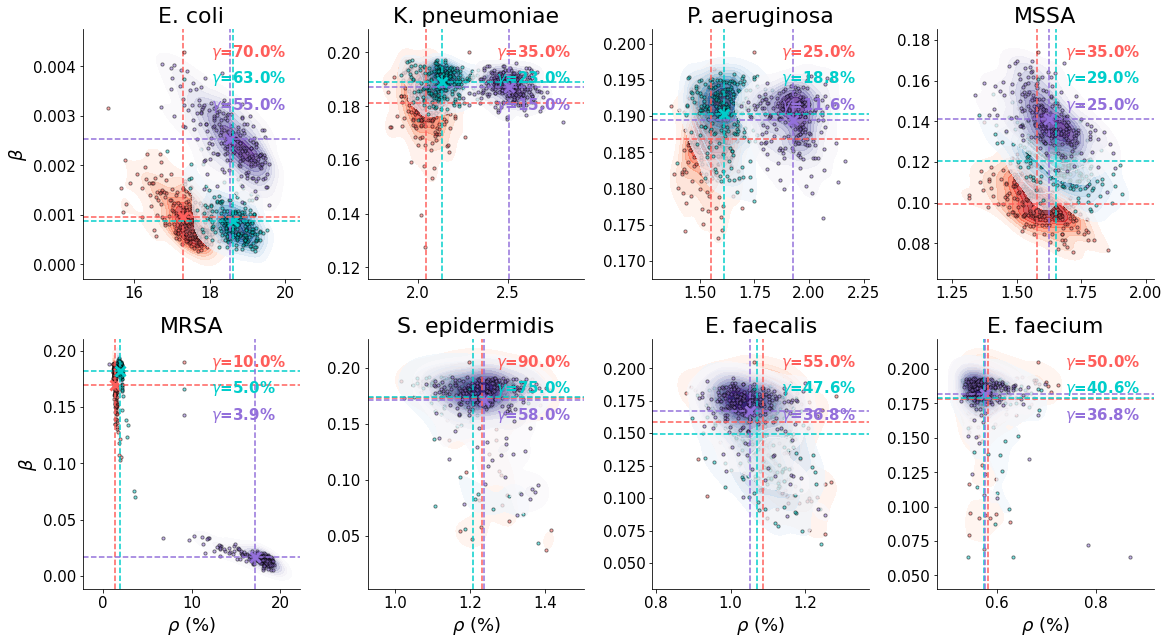

In [91]:
from diagnostic_plots import convergence_plot
from utils_local import plot_utils
import seaborn as sns


COLORS_GAMMA = ["#ff5e5b", "#00cecb", "mediumpurple"]
CMAPS_GAMMA  = ["Reds", "Blues", "Purples"]
v_df = posterior_df[posterior_df["if_iter"] == Nif-1]

fig, ax = plt.subplots(2, 4, figsize=(16.5, 9.2), sharex=False, sharey=False)

for idx_axi, axi in enumerate(ax.flatten()):
    amro    = amro_search[idx_axi]
    amro_df = v_df[v_df.amro==amro]
    gammas  = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    for idx_g, gamma in enumerate(gammas):
        rho_df  = amro_df.query(f"gamma=={gamma} and param=='ρ'")
        beta_df = amro_df.query(f"gamma=={gamma} and param=='β'")

        sns.kdeplot(ax    = axi,
                    x     = rho_df["value"].values * 100,
                    y     = beta_df["value"].values,
                    cmap  = CMAPS_GAMMA[idx_g],
                    fill  = True,
                    alpha = 0.7)

        axi.scatter(rho_df["value"].values * 100,
                    beta_df["value"].values,
                    facecolor = COLORS_GAMMA[idx_g],
                    edgecolor = "k",
                    alpha     = 0.5,
                    s         = 10,
                    label     = r"$\gamma$="+"{:0.1f}%".format(gamma*100))

        axi.axhline(y     = np.mean(beta_df["value"].values),
                    ls    = "--",
                    color = COLORS_GAMMA[idx_g])

        axi.axvline(x     = np.mean(rho_df["value"].values*100),
                    ls    = "--",
                    color = COLORS_GAMMA[idx_g])

        axi.scatter(x          = np.mean(rho_df["value"].values) * 100,
                    y         = np.mean(beta_df["value"].values),
                    marker    = "x",
                    facecolor = COLORS_GAMMA[idx_g],
                    lw        = 3,
                    s         = 100)

    l = axi.legend(loc      = "upper right",
                    frameon = False,
                    prop    = {"weight": 'bold'})

    for idx_t, text in enumerate(l.get_texts()):
        text.set_color(COLORS_GAMMA[idx_t])

    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_title(amro2title(amro))
    axi.set_ylabel(None)
    axi.set_xlabel(None)

ax[0, 0].set_ylabel(r"$\beta$")
ax[1, 0].set_ylabel(r"$\beta$")

for i in range(4):
    ax[1, i].set_xlabel(r"$\rho$ (%)")

plt.tight_layout()

<ipython-input-128-45be4b8d4b87>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rho_df["gamma_plt"] = np.round(rho_df.gamma.values * 100, 2)
<ipython-input-128-45be4b8d4b87>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rho_df["value"]     = rho_df["value"].map(lambda x: x*100)
<ipython-input-128-45be4b8d4b87>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

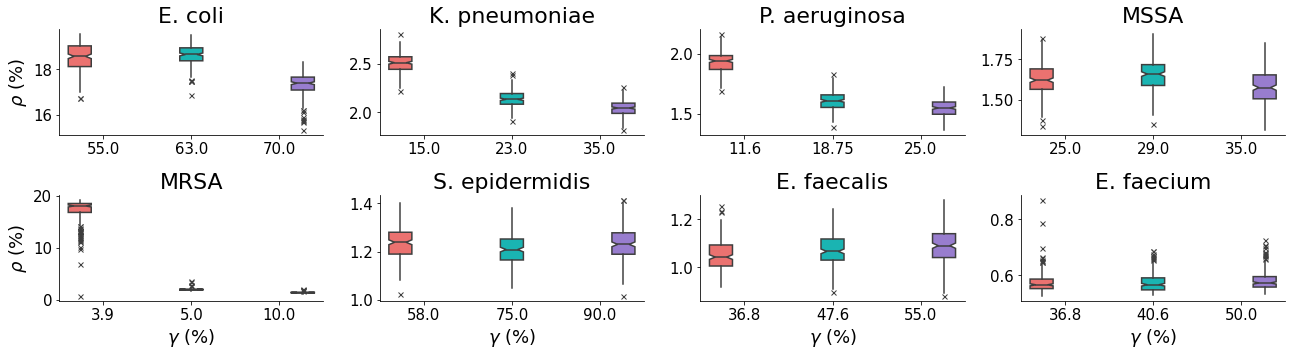

In [128]:

fig, ax = plt.subplots(2, 4, figsize=(18.2, 5.2))
for idx_axi, axi in enumerate(ax.flatten()):

    amro                = amro_search[idx_axi]
    amro_df             = v_df[v_df.amro==amro]
    rho_df              = amro_df.query(f"param=='ρ'")
    beta_df             = amro_df.query(f"param=='β'")
    rho_df["gamma_plt"] = np.round(rho_df.gamma.values * 100, 2)
    rho_df["value"]     = rho_df["value"].map(lambda x: x*100)

    sns.boxplot(
        ax         = axi,
        data       = rho_df,
        x          = "gamma_plt",
        y          = "value",
        hue        = "gamma_plt",
        notch      = True,
        showcaps   = False,
        palette    = COLORS_GAMMA,
        flierprops = {"marker": "x"})

    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

    axi.set_title(amro2title(amro))
    axi.legend().remove()
    axi.set_ylabel(None)
    axi.set_xlabel(None)


ax[0, 0].set_ylabel(r"$\rho$ (%)")
ax[1, 0].set_ylabel(r"$\rho$ (%)")

for i in range(4):
    ax[1, i].set_xlabel(r"$\gamma$ (%)")
plt.tight_layout()

<ipython-input-133-5cab391e4656>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_df["gamma_plt"] = np.round(beta_df.gamma.values * 100, 2)
<ipython-input-133-5cab391e4656>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_df["gamma_plt"] = np.round(beta_df.gamma.values * 100, 2)
<ipython-input-133-5cab391e4656>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

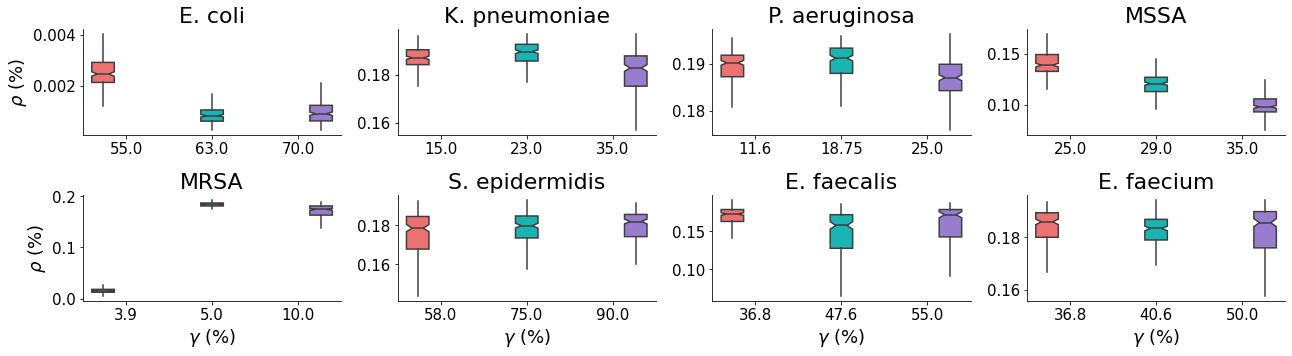

In [133]:

fig, ax = plt.subplots(2, 4, figsize=(18.2, 5.2))
for idx_axi, axi in enumerate(ax.flatten()):

    amro                = amro_search[idx_axi]
    amro_df             = v_df[v_df.amro==amro]
    rho_df              = amro_df.query(f"param=='ρ'")
    beta_df             = amro_df.query(f"param=='β'")
    beta_df["gamma_plt"] = np.round(beta_df.gamma.values * 100, 2)

    sns.boxplot(
        ax         = axi,
        data       = beta_df,
        x          = "gamma_plt",
        y          = "value",
        hue        = "gamma_plt",
        notch      = True,
        showcaps   = False,
        palette    = COLORS_GAMMA,
        showfliers = False)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

    axi.set_title(amro2title(amro))
    axi.legend().remove()
    axi.set_ylabel(None)
    axi.set_xlabel(None)


ax[0, 0].set_ylabel(r"$\rho$ (%)")
ax[1, 0].set_ylabel(r"$\rho$ (%)")

for i in range(4):
    ax[1, i].set_xlabel(r"$\gamma$ (%)")
plt.tight_layout()